In [2]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import os


plt.style.use('fivethirtyeight')
script_dir = os.path.abspath('')
data_dir = f"{script_dir}/data/" + "{ticker}.csv"
data_dir

2024-05-22 09:58:54.359113: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-22 09:58:54.362257: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-22 09:58:54.412987: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-22 09:58:54.722979: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-22 09:58:56.093215: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

'/home/eris29/APCSA/CSA_AI_Flask_Backend/lstm/data/{ticker}.csv'

In [3]:
class StockDataFrame:
    def __init__(self, ticker):
        self.__ticker = ticker
        self.__data_dir = data_dir
        self.__ticker_data_path = data_dir.format(ticker=self.__ticker.upper())
        self.__stock_df = None
    
    def generate_data_frame(self):
        self.__stock_df = pd.read_csv(self.__ticker_data_path)
        self.__stock_df.set_index('Date', inplace=True)
    
    def get_data_frame(self):
        return self.__stock_df
    
    def get_ticker(self):
        return self.__ticker

# Create a StockDataFrame instance for AAPL and generate the DataFrame
AAPLDF = StockDataFrame("AAPL")
AAPLDF.generate_data_frame()
aapl_df = AAPLDF.get_data_frame()
aapl_df



,Symbol,Open,Close,Low,High,Volume
Date,,,,,,
2014-05-21,AAPL,21.565357,21.653929,21.502144,21.667856,196859600
2014-05-22,AAPL,21.664286,21.688213,21.575001,21.780357,200760000
2014-05-23,AAPL,21.687500,21.933214,21.659643,21.954643,232209600
2014-05-27,AAPL,21.995714,22.343929,21.986786,22.352142,348866000
2014-05-28,AAPL,22.357857,22.286072,22.277857,22.493929,315481600
...,...,...,...,...,...,...
2024-05-14,AAPL,187.509995,187.429993,186.289993,188.300003,52393600
2024-05-15,AAPL,187.910004,189.720001,187.369995,190.649994,70400000
2024-05-16,AAPL,190.470001,189.839996,189.660004,191.100006,52845200


In [4]:
aapl_df.shape

(2517, 6)

/home/eris29/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1954/1954 ━━━━━━━━━━━━━━━━━━━━ 51s 25ms/step - loss: 0.0021
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


/tmp/ipykernel_657406/3602055142.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = data['predictions']


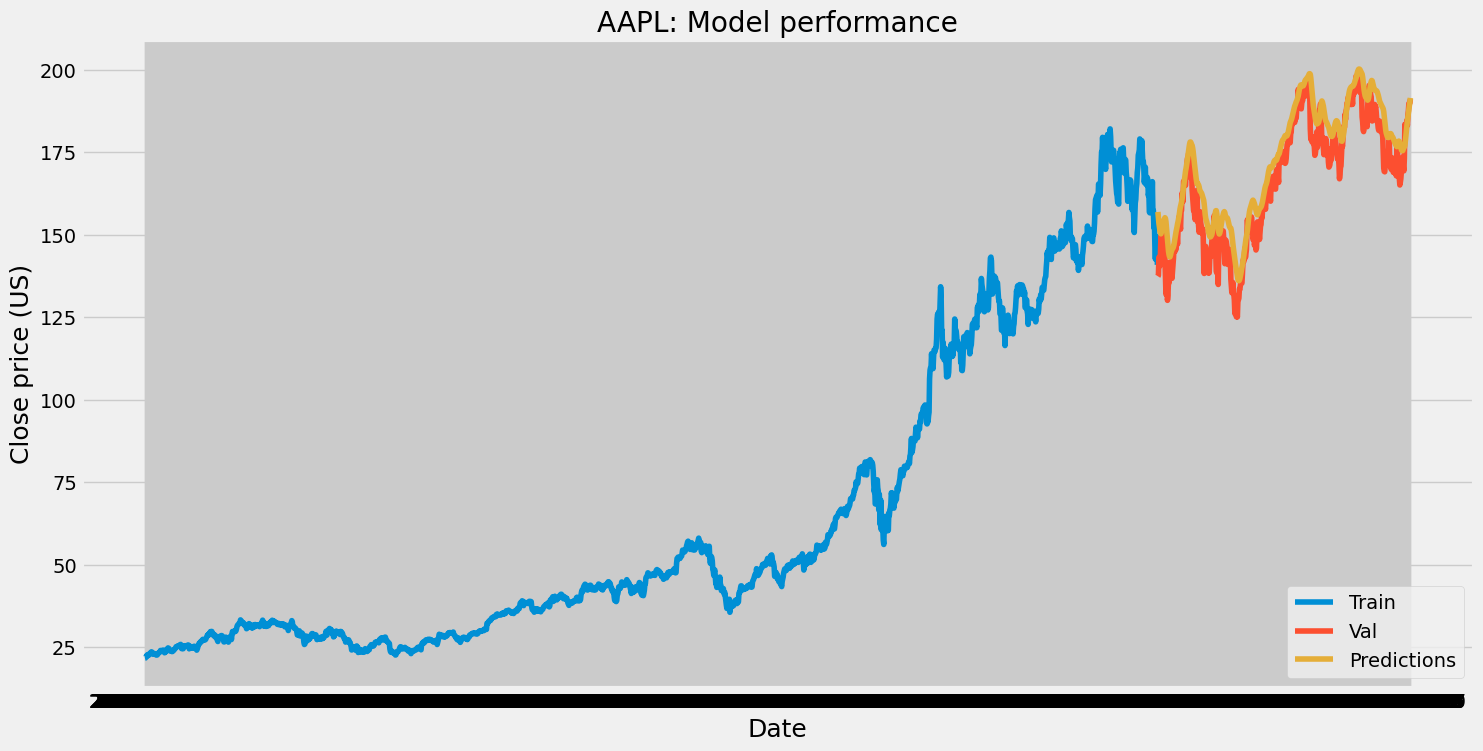

Predictions exported to /home/eris29/APCSA/CSA_AI_Flask_Backend/lstm/predictions/{ticker}.csv
None


/home/eris29/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1954/1954 ━━━━━━━━━━━━━━━━━━━━ 51s 25ms/step - loss: 0.0018
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Predictions exported to /home/eris29/APCSA/CSA_AI_Flask_Backend/lstm/predictions/AAPL.csv
None


<Figure size 640x480 with 0 Axes>

In [7]:
class LSTMClass:
    __script_dir = os.path.abspath('')
    __prediction_destination = f"{__script_dir}/predictions/" + "{ticker}.csv" 
    __graph_destination = f"{__script_dir}/graphs/" + "{ticker}.png" 
    def __init__(self, ticker, stock_data):
        self.__ticker = ticker
        self.__stock_data = stock_data
        self.__scaler = MinMaxScaler(feature_range=(0,1))

    def plot_data(self):
        plt.figure(figsize=(16,8))
        plt.title(self.__ticker + ": Close Price History")
        plt.plot(self.__stock_data['Close'])    
        plt.xlabel('Date', fontsize=18)
        plt.ylabel('Close price (US)', fontsize=18)
        plt.show()
    
    def scale_split_data(self):
        # Get close data
        close_data = self.__stock_data.filter(['Close'])
        close_dataset = close_data.values
        training_data_len = math.ceil(len(close_dataset) * .8)

        # Scale the data
        scaled_close_data = self.__scaler.fit_transform(close_dataset)
        training_data = scaled_close_data[0:training_data_len, :]
        test_data = scaled_close_data[training_data_len - 60:, :]

        # Split to Xtrain and Ytrain
        x_train = []
        y_train = []

        # Split to X_test and y_test
        x_test = []
        y_test = close_dataset[training_data_len:, :]

        for i in range(60, len(training_data)):
            x_train.append(training_data[i-60:i, 0])
            y_train.append(training_data[i, 0])

        for i in range(60, len(test_data)):
            x_test.append(test_data[i-60:i, 0])

        x_test = np.array(x_test)
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

        x_train, y_train = np.array(x_train), np.array(y_train)
        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

        data = {"x_train" : x_train, "y_train" : y_train, "x_test": x_test, "y_test": y_test, "training_data_len": training_data_len}
        return data
    
    def load_model(self):
        x_train, y_train = self.scale_split_data()['x_train'], self.scale_split_data()['y_train']
        model = Sequential()
        model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
        model.add(LSTM(50, return_sequences=False))
        model.add(Dense(25))
        model.add(Dense(1))
        return model
    
    def train_and_predict_LSTM_model(self):
        data = self.scale_split_data()
        x_train, y_train, x_test, y_test = data['x_train'], data['y_train'], data['x_test'], data['y_test']
        model = self.load_model()
        model.compile(optimizer='adam', loss='mean_squared_error')
        model.fit(x_train, y_train, batch_size=1, epochs=1)
        predictions = model.predict(x_test)
        predictions = self.__scaler.inverse_transform(predictions)
        rmse_metric = np.sqrt( np.mean(predictions - y_test)**2)
        data['predictions'] = predictions
        data['rmse'] = rmse_metric
        return data

    def graph_predicted_data(self):
        data = self.train_and_predict_LSTM_model()
        close_data = self.__stock_data.filter(['Close'])
        train = close_data[:data['training_data_len']]
        valid = close_data[data['training_data_len']:]
        valid['Predictions'] = data['predictions']
        plt.figure(figsize=(16,8))
        plt.title(self.__ticker + ": Model performance")  
        plt.xlabel('Date', fontsize=18)
        plt.ylabel('Close price (US)', fontsize=18)
        plt.plot(train['Close'])
        plt.plot(valid[['Close', 'Predictions']])
        plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
        plt.show()
        plt.savefig(self.__graph_destination.format(ticker=self.__ticker))
        
    def export_predictions_to_csv(self):
        data = self.train_and_predict_LSTM_model()
        valid = self.__stock_data[self.scale_split_data()['training_data_len']:].copy()
        valid['Predictions'] = data['predictions']
        predictions_df = valid[['Close', 'Predictions']].reset_index()
        predictions_df.columns = ['Date', 'Actual', 'Predictions']
        predictions_df.to_csv(self.__prediction_destination.format(ticker=self.__ticker), index=False)
        print(f"Predictions exported to {self.__prediction_destination.format(ticker=self.__ticker)}")
        
    
        
AAPL_obj = LSTMClass("AAPL", aapl_df)
print(AAPL_obj.graph_predicted_data())
print(AAPL_obj.export_predictions_to_csv())
